# The Shower Problem

This notebook is one of the examples in the second edition of [*Think Bayes*](https://greenteapress.com/wp/think-bayes/).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/examples/shower.ipynb).

Recently I [posted an article](https://t.co/MZgb3845Ol?amp=1) about an optimal (maybe) strategy for plugging in a USB connector.

I tweeted about the article and got [a reply from Cameron Davidson-Pilon](https://twitter.com/Cmrn_DP/status/1407159305904795658) that pointed me to [a related problem posted by Chris Said](https://chris-said.io/2020/02/08/the-shower-problem/):

> #### The Shower Problem
>
> Here’s the setup: You’re at your friend’s place and you need to take a shower. The shower knob is unlabeled. One direction is hot and the other direction is cold, and you don’t know which is which.
>
> You turn it to the left. It’s cold. You wait.
>
>At what point do you switch over to the right?
>
> Let’s make this more explicit.
>
> * Your goal is to find a policy that minimizes the expected amount of time it takes to get hot water flowing out of the shower head. To simplify things, assume that the water coming out of the head is either hot or cold, and that the lukewarm transition time is effectively zero.
>
> * You know that the shower has a Time-To-Hot constant called $\tau$. This value is defined as the time it takes for hot water to arrive, assuming you have turned the knob to the hot direction and keep it there.
>
> * The constant is a fixed property of the shower and is sampled once from a known distribution. You have certain knowledge of the distribution, but you don’t know $\tau$.
>
> * The shower is memoryless, such that every time you turn the knob to the hot direction, it will take $\tau$ seconds until the hot water arrives, regardless of your prior actions. Every time you turn it to the cold direction, only cold water will come out.
>
> I don’t know how to solve this problem. But as a starting point I realize it’s possible to keep track of the probability that the hot direction is to the left or to the right. In the animation above, the probability that the hot direction is to the right is just the unexplored white area under the right curve, divided by the total unexplored white area of both curves.
>
> But how do you turn that into a policy for exploring the space? Does anybody know?

Chris provides [a sample of 20,000 values for the time constant](https://gist.github.com/csaid/a57c4ebaa1c7b0671cdc9692638ea4c4) and the additional information that the distribution of $tau$ is Weibull with parameters $\lambda=50$ and $k=1.5$.

Also, Chris keeps track of the leader board for best strategy. At the moment, the leader is Cameron Davidson-Pilon himself, with an average duration of 111.365 seconds.

So let's see if we can do any better. As in the previous problem, I'm going to start with the conjecture that the optimal strategy is to stay on the first side until the probability that you are on the right side drops below some threshold, then switch to the second side and stay until the probability drops below the same threshold.

I am not confident that this strategy is actually optimal, but let's see if it does a decent job.

Suppose we try on the first side for $t_1$ seconds and then try on the second side for $t_2$ seconds. At that point, we can use the survival function of the Weibull distribution to compute the log odds that the second side is correct:

$$ LO = \left( \frac{t_1}{\lambda} \right)^k - \left( \frac{t_2}{\lambda} \right)^k$$

Now suppose we want to stay on the current side until the log odds we're on the wrong side exceeds some threshold, `x`, and the time we've spent on the other side is `other`. 
The following function computes how long we should stay.

In [1]:
def wait_time(x, other, lam, k):
    term = (other / lam) ** k
    total = lam * (x + term) ** (1/k)
    return total

Starting with $t_1=0$ and $t_2=0$, when $x=1$, the time we wait turns out to be $\lambda$. 

In [2]:
right = 0
left = 0
x = 1
lam = 50
k = 1.5

right = wait_time(x, left, lam, k)
right

50.0

Now suppose we've waited 50 seconds on the left and we switch to the right. How long should we stay?

In [3]:
left = wait_time(x, right, lam, k)
left

79.37005259840997

And now if we've spent `left` second on the left and switch to the right, how long should we stay.

In [4]:
right = wait_time(x, left, lam, k)
right

104.00419115259521

But all of that is based on the assumption that `x=1`. Let's see what happens to the average total time as we vary `x`.

## Simulation

The following function simulates the strategy I just outlined.
It takes as parameters:

* `correct`: A Boolean indicating if we're on the right side.
* `tau`: The actual time to get hot water.
* `this`: The longest time we've tried on the current side.
* `that`: The longest time we've tried on the other side..
* `lam`: The scale parameter for the distribution of time until success.
* `k`: The shape parameter for the distribution of time until success.
* `x`: The threshold for the posterior log odds.
* `trace`: A list that indicates how much time we have spent, so far, trying and flipping.

It runs the simulation and returns a sequence of waiting times. The sum of this sequence is the total time it took to connect.

In [5]:
def simulate(correct, tau, this, that, lam, k, x, trace):
    if len(trace) > 20:
        return 'Too many recursions'
    
    # print(correct, tau, this, that, lam, k, x, trace)
    
    # figure out the maximum time we should try before flipping
    wait = wait_time(x, that, lam, k)
    
    # if we're on the correct side, see if we succeed before time's up
    if correct and tau < wait:
        # if so, update and return the trace
        return trace + [tau]
    
    # if time expired, add the wait time to the trace  
    # and make a recursive call to continue the simulation
    return simulate(not correct, tau, that, wait, lam, k, x, trace + [wait])

Here are a few test runs with `x=0.5` and various values of `correct` and `tau`.

In [6]:
x = 0.5
simulate(True, 20, 0, 0, lam, k, x, [])

[20]

In [7]:
simulate(False, 20, 0, 0, lam, k, x, [])

[31.49802624737183, 20]

In [8]:
simulate(True, 40, 0, 0, lam, k, x, [])

[31.49802624737183, 50.0, 40]

In [9]:
simulate(False, 40, 0, 0, lam, k, x, [])

[31.49802624737183, 40]

In [10]:
simulate(True, 60, 0, 0, lam, k, x, [])

[31.49802624737183, 50.0, 60]

In [11]:
simulate(False, 60, 0, 0, lam, k, x, [])

[31.49802624737183, 50.0, 65.51853485522241, 60]

In [12]:
simulate(True, 120, 0, 0, lam, k, x, [])

[31.49802624737183,
 50.0,
 65.51853485522241,
 79.37005259840997,
 92.10078746600966,
 104.00419115259518,
 115.26090730146115,
 125.9921049894873,
 120]

In [13]:
simulate(False, 120, 0, 0, lam, k, x, [])

[31.49802624737183,
 50.0,
 65.51853485522241,
 79.37005259840997,
 92.10078746600966,
 104.00419115259518,
 115.26090730146115,
 120]

Let's get the test data from Chris.

In [14]:
import os

if not os.path.exists('shower_problem_tau_samples.csv'):
    !wget https://gist.github.com/csaid/a57c4ebaa1c7b0671cdc9692638ea4c4/raw/ad1709938834d7bc88b62ff0763733502eb6a329/shower_problem_tau_samples.csv

In [15]:
import pandas as pd

test_set = pd.read_csv('shower_problem_tau_samples.csv')
test_set.head()

,direction,tau
0,1.0,44.173094
1,1.0,39.133131
2,1.0,2.229446
3,1.0,45.518857
4,1.0,32.463695


In [16]:
test_set.describe()

,direction,tau
count,20000.000000,20000.000000
mean,0.503050,45.159284
std,0.500003,30.668965
min,0.000000,0.030405
25%,0.000000,21.942625
50%,1.000000,39.133399
75%,1.000000,62.153967
max,1.000000,289.412577


The following function uses the samples to run simulations and returns the average total time.

In [17]:
import numpy as np

def run_simulations(samples, lam, k, x):
    res = []
    for i, (direction, tau) in samples.iterrows():
        # print(direction, tau)
        trace = simulate(direction, tau, 0, 0, lam, k, x, [])
        res.append((len(trace), sum(trace)))
        
    return np.transpose(res)

I'll train the algorithm with a different sample from the same distribution.

In [18]:
from scipy.stats import weibull_min

train_set = test_set.copy()
train_set['tau'] = weibull_min.rvs(k, scale=lam, size=20000)

In [19]:
train_set.describe()

,direction,tau
count,20000.000000,20000.000000
mean,0.503050,44.557424
std,0.500003,30.313085
min,0.000000,0.066406
25%,0.000000,21.373571
50%,1.000000,38.453915
75%,1.000000,61.319590
max,1.000000,214.395690


Here's a test run with `x=1`.

In [20]:
x = 1
lengths, totals = run_simulations(train_set, lam, k, x)

On average it takes about two tries and 116 seconds.

In [21]:
lengths.mean()

2.06775

In [22]:
totals.mean()

114.42226252245712

## Optimization

Now let's see how the average duration varies as we sweep through a range of values for the threshold probability, `r`:

In [23]:
xs = np.linspace(1, 3, 20)
xs

array([1.        , 1.10526316, 1.21052632, 1.31578947, 1.42105263,
       1.52631579, 1.63157895, 1.73684211, 1.84210526, 1.94736842,
       2.05263158, 2.15789474, 2.26315789, 2.36842105, 2.47368421,
       2.57894737, 2.68421053, 2.78947368, 2.89473684, 3.        ])

In [24]:
res = []
for x in xs:
    lengths, totals = run_simulations(train_set, lam, k, x)
    res.append((x, totals.mean()))

In [25]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    endog = series.values
    exog = series.index.values

    smooth = lowess(endog, exog)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [26]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    series.plot(lw=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

Here's what the results look like.

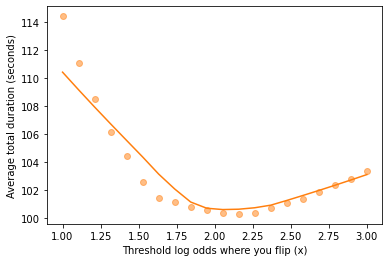

In [27]:
import matplotlib.pyplot as plt

rs, ts = np.transpose(res)
series = pd.Series(ts, rs)

plot_series_lowess(series, 'C1')

plt.xlabel("Threshold log odds where you flip (x)")
plt.ylabel("Average total duration (seconds)");

It looks like the optimal value of `x` is about 2.

## Testing

Now let's run the simulations with the optimal value of `x` and see what the average total time is for the test data.

In [28]:
lengths, totals = run_simulations(test_set, lam, k, 2)

The average total time is about 102 seconds, so it looks like this strategy is better than the current leader (assuming I haven't made a mistake in the simulation).

In [29]:
totals.mean()

101.8357533856479

Here's the distribution of total time, represented as a CDF.

In [30]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

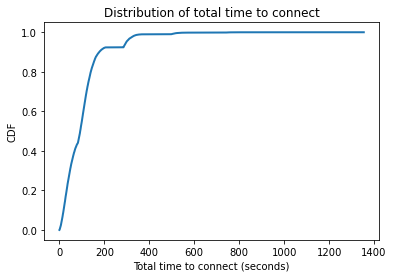

In [31]:
from empiricaldist import Cdf

Cdf.from_seq(totals).plot(lw=2)

plt.xlabel('Total time to connect (seconds)')
plt.ylabel('CDF')
plt.title('Distribution of total time to connect');

In [32]:
np.percentile(totals, 90)

177.15320163579483

And here's the distribution of flips.

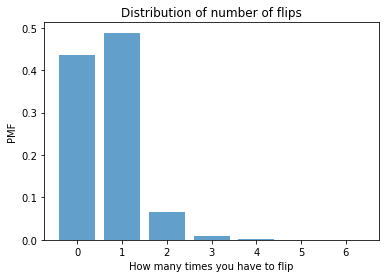

In [33]:
from empiricaldist import Pmf

pmf1 = Pmf.from_seq(lengths-1)
pmf1.bar(alpha=0.7)

plt.xlabel('How many times you have to flip')
plt.ylabel('PMF')
plt.title('Distribution of number of flips');

Fortunately, we don't have to flip more than once very often.

*If you like this article, you might also like the second edition of [*Think Bayes*](https://greenteapress.com/wp/think-bayes/).*

Copyright 2021 Allen Downey

Code: [MIT License](https://opensource.org/licenses/MIT)

Text: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)